In [1]:
from data import *
import torch.utils.data
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean', keep_empty_features=True)
train_dataset, test_dataset = get_coord_transfer_dataset(imputer)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=None)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=None)

In [2]:
import logging
import time
local_time = time.localtime()
formatter = logging.Formatter(u'%(asctime)s [%(levelname)8s] %(message)s')
file_handler = logging.FileHandler(f'./log/{local_time.tm_year}.{local_time.tm_mon:02}.{local_time.tm_mday:02}.{local_time.tm_hour:02}-{local_time.tm_min:02}-{local_time.tm_sec:02}.log', 'w')
file_handler.setFormatter(formatter)
logger = logging.Logger('main', logging.DEBUG)
logger.addHandler(file_handler)

In [3]:
def seed_everything(seed=42):
    import torch
    import random
    import numpy as np
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False
    np.random.seed(seed)
    random.seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [4]:
import optuna
from model import *
import torch

def objective(trial:optuna.trial.Trial):
    seed_everything()
    input_size = next(iter(train_dataset))[0].shape[-1]
    output_size = next(iter(train_dataset))[1].shape[-1]

    num_epoch = 100

    model_name = trial.suggest_categorical('model', ['LSTM'])
    if model_name == 'LSTM':
        hidden_size = trial.suggest_categorical('lstm_hidden_size', [8, 16, 32, 64, 128])
        num_layer = trial.suggest_int('lstm_num_layer', 1, 4)
        model = LSTM(input_size, hidden_size, num_layer, output_size)
    
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'Adagrad', 'SGD'])
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1, log=True)
    if optimizer_name == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'Adagrad':
        optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
    scheduler_name = trial.suggest_categorical('scheduler',[ 'CosineAnnealingLR'])
    if scheduler_name == 'CosineAnnealingLR':
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epoch)
    
    criterion = torch.nn.MSELoss()

    
    from tensorboardX import SummaryWriter
    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import mean_absolute_error
    writer = SummaryWriter()
    
    best_rmse = float('inf')
    for epoch in range(num_epoch):
        model.train()
        criterion.train()
        for X, y in train_loader:
            pred = model(X)
            loss = criterion(pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if scheduler_name == 'CosineAnnealingLR':
            scheduler.step()

        model.eval()
        criterion.eval()
        with torch.no_grad():
            mae = []
            mse = []
            num = []
            for X, y in test_loader:
                pred = model(X)
                try:
                    mae.append(mean_absolute_error(y, pred))
                    mse.append(mean_squared_error(y, pred))
                    num.append(len(y))
                except ValueError:
                    print(f'{epoch=}')
                    print(f'{trial.params=}')
                    print(f'{y=}')
                    print(f'{pred=}')
                    return best_rmse
            mae = np.array(mae)
            mse = np.array(mse)
            num = np.array(num)
            mae = (mae * num).sum() / sum(num)
            mse = (mse * num).sum() / sum(num)
            
            rmse = mse ** 0.5
            writer.add_scalar('metric/MAE', mae, epoch)
            writer.add_scalar('metric/RMSE', rmse, epoch)
            best_rmse = min(rmse, best_rmse)
            
            trial.report(rmse, epoch)
            if trial.should_prune():
                raise optuna.TrialPruned()
    
    return best_rmse

study = optuna.create_study()
study.optimize(objective, n_trials=100)

[I 2023-05-26 04:51:37,978] A new study created in memory with name: no-name-f5971097-693a-4e3f-9f8f-81e547907bf0
[I 2023-05-26 04:53:07,091] Trial 0 finished with value: 8.61910446848904 and parameters: {'model': 'LSTM', 'lstm_hidden_size': 64, 'lstm_num_layer': 1, 'optimizer': 'Adagrad', 'learning_rate': 0.00033848703724205325, 'scheduler': 'CosineAnnealingLR'}. Best is trial 0 with value: 8.61910446848904.
[I 2023-05-26 04:58:37,276] Trial 1 finished with value: 1.9071217357274874 and parameters: {'model': 'LSTM', 'lstm_hidden_size': 64, 'lstm_num_layer': 4, 'optimizer': 'Adam', 'learning_rate': 0.006156552255072837, 'scheduler': 'CosineAnnealingLR'}. Best is trial 1 with value: 1.9071217357274874.
[I 2023-05-26 05:01:45,990] Trial 2 finished with value: 1.9589330528675233 and parameters: {'model': 'LSTM', 'lstm_hidden_size': 32, 'lstm_num_layer': 4, 'optimizer': 'Adagrad', 'learning_rate': 0.010895114833714355, 'scheduler': 'CosineAnnealingLR'}. Best is trial 1 with value: 1.907121

In [5]:
study.best_params

{'model': 'LSTM',
 'lstm_hidden_size': 128,
 'lstm_num_layer': 3,
 'optimizer': 'Adam',
 'learning_rate': 0.0037953524733919945,
 'scheduler': 'CosineAnnealingLR'}

In [6]:
study.best_trial

FrozenTrial(number=12, state=TrialState.COMPLETE, values=[1.9044828567086636], datetime_start=datetime.datetime(2023, 5, 26, 5, 5, 28, 787319), datetime_complete=datetime.datetime(2023, 5, 26, 5, 13, 29, 841538), params={'model': 'LSTM', 'lstm_hidden_size': 128, 'lstm_num_layer': 3, 'optimizer': 'Adam', 'learning_rate': 0.0037953524733919945, 'scheduler': 'CosineAnnealingLR'}, user_attrs={}, system_attrs={}, intermediate_values={0: 2.015677601116404, 1: 2.0535978621738593, 2: 2.063748855675744, 3: 2.0744811080985337, 4: 2.098303805091077, 5: 2.1135085561408142, 6: 2.1249006679715925, 7: 2.1230584235742134, 8: 2.123855877086011, 9: 2.1241086234602062, 10: 2.1240832749153826, 11: 2.1234900687253293, 12: 2.1225095729500767, 13: 2.121172751984896, 14: 2.11954855777373, 15: 2.1176600851766785, 16: 2.1155487663391446, 17: 2.113242182464743, 18: 2.1107637615657535, 19: 2.1081504222488134, 20: 2.1053327455332838, 21: 2.102405309236787, 22: 2.0993524843297338, 23: 2.09618859728764, 24: 2.092920

In [7]:
study.best_trials

[FrozenTrial(number=12, state=TrialState.COMPLETE, values=[1.9044828567086636], datetime_start=datetime.datetime(2023, 5, 26, 5, 5, 28, 787319), datetime_complete=datetime.datetime(2023, 5, 26, 5, 13, 29, 841538), params={'model': 'LSTM', 'lstm_hidden_size': 128, 'lstm_num_layer': 3, 'optimizer': 'Adam', 'learning_rate': 0.0037953524733919945, 'scheduler': 'CosineAnnealingLR'}, user_attrs={}, system_attrs={}, intermediate_values={0: 2.015677601116404, 1: 2.0535978621738593, 2: 2.063748855675744, 3: 2.0744811080985337, 4: 2.098303805091077, 5: 2.1135085561408142, 6: 2.1249006679715925, 7: 2.1230584235742134, 8: 2.123855877086011, 9: 2.1241086234602062, 10: 2.1240832749153826, 11: 2.1234900687253293, 12: 2.1225095729500767, 13: 2.121172751984896, 14: 2.11954855777373, 15: 2.1176600851766785, 16: 2.1155487663391446, 17: 2.113242182464743, 18: 2.1107637615657535, 19: 2.1081504222488134, 20: 2.1053327455332838, 21: 2.102405309236787, 22: 2.0993524843297338, 23: 2.09618859728764, 24: 2.09292

In [8]:
import pickle
pickle.dump(study, open('./study3.pkl', 'wb'))

In [9]:
study.best_value

1.9044828567086636

In [10]:
df = study.trials_dataframe()
df

,number,value,datetime_start,datetime_complete,duration,params_learning_rate,params_lstm_hidden_size,params_lstm_num_layer,params_model,params_optimizer,params_scheduler,state
0,0,8.619104,2023-05-26 04:51:37.979370,2023-05-26 04:53:07.091794,0 days 00:01:29.112424,0.000338,64,1,LSTM,Adagrad,CosineAnnealingLR,COMPLETE
1,1,1.907122,2023-05-26 04:53:07.092792,2023-05-26 04:58:37.275668,0 days 00:05:30.182876,0.006157,64,4,LSTM,Adam,CosineAnnealingLR,COMPLETE
2,2,1.958933,2023-05-26 04:58:37.277669,2023-05-26 05:01:45.989946,0 days 00:03:08.712277,0.010895,32,4,LSTM,Adagrad,CosineAnnealingLR,COMPLETE
3,3,4.747124,2023-05-26 05:01:45.991947,2023-05-26 05:02:21.840945,0 days 00:00:35.848998,0.013131,8,1,LSTM,Adagrad,CosineAnnealingLR,COMPLETE
4,4,1.906343,2023-05-26 05:02:21.841944,2023-05-26 05:03:41.940326,0 days 00:01:20.098382,0.023705,8,2,LSTM,Adam,CosineAnnealingLR,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,2.129876,2023-05-26 06:25:12.291893,2023-05-26 06:25:24.844895,0 days 00:00:12.553002,0.008268,64,4,LSTM,Adam,CosineAnnealingLR,PRUNED
96,96,4.578491,2023-05-26 06:25:24.847895,2023-05-26 06:25:30.246414,0 days 00:00:05.398519,0.001399,128,3,LSTM,Adam,CosineAnnealingLR,PRUNED
97,97,10.926687,2023-05-26 06:25:30.249413,2023-05-26 06:25:31.152639,0 days 00:00:00.903226,0.002407,16,2,LSTM,Adagrad,CosineAnnealingLR,PRUNED
98,98,6.194355,2023-05-26 06:25:31.154634,2023-05-26 06:25:31.618636,0 days 00:00:00.464002,0.014363,8,1,LSTM,Adam,CosineAnnealingLR,PRUNED


In [11]:
df[df['params_optimizer'] == 'Adagrad']

,number,value,datetime_start,datetime_complete,duration,params_learning_rate,params_lstm_hidden_size,params_lstm_num_layer,params_model,params_optimizer,params_scheduler,state
0,0,8.619104,2023-05-26 04:51:37.979370,2023-05-26 04:53:07.091794,0 days 00:01:29.112424,0.000338,64,1,LSTM,Adagrad,CosineAnnealingLR,COMPLETE
2,2,1.958933,2023-05-26 04:58:37.277669,2023-05-26 05:01:45.989946,0 days 00:03:08.712277,0.010895,32,4,LSTM,Adagrad,CosineAnnealingLR,COMPLETE
3,3,4.747124,2023-05-26 05:01:45.991947,2023-05-26 05:02:21.840945,0 days 00:00:35.848998,0.013131,8,1,LSTM,Adagrad,CosineAnnealingLR,COMPLETE
19,19,11.209885,2023-05-26 05:17:16.677408,2023-05-26 05:17:19.420406,0 days 00:00:02.742998,0.000117,128,2,LSTM,Adagrad,CosineAnnealingLR,PRUNED
29,29,9.326830,2023-05-26 05:40:12.262329,2023-05-26 05:40:13.829330,0 days 00:00:01.567001,0.000871,128,1,LSTM,Adagrad,CosineAnnealingLR,PRUNED
30,30,9.284783,2023-05-26 05:40:13.831329,2023-05-26 05:40:18.064331,0 days 00:00:04.233002,0.000580,128,3,LSTM,Adagrad,CosineAnnealingLR,PRUNED
36,36,8.477391,2023-05-26 05:46:46.362598,2023-05-26 05:46:47.599595,0 days 00:00:01.236997,0.012758,16,4,LSTM,Adagrad,CosineAnnealingLR,PRUNED
48,48,8.795543,2023-05-26 06:01:02.191127,2023-05-26 06:01:06.454126,0 days 00:00:04.262999,0.000802,128,3,LSTM,Adagrad,CosineAnnealingLR,PRUNED
64,64,8.993615,2023-05-26 06:06:00.051873,2023-05-26 06:06:02.914047,0 days 00:00:02.862174,0.001761,64,4,LSTM,Adagrad,CosineAnnealingLR,PRUNED
76,76,10.957211,2023-05-26 06:24:07.280857,2023-05-26 06:24:09.397859,0 days 00:00:02.117002,0.002908,8,4,LSTM,Adagrad,CosineAnnealingLR,PRUNED


In [12]:
df = df[df['state']=='COMPLETE'].drop(['number', 'datetime_start', 'datetime_complete', 'state'], axis=1)
df

,value,duration,params_learning_rate,params_lstm_hidden_size,params_lstm_num_layer,params_model,params_optimizer,params_scheduler
0,8.619104,0 days 00:01:29.112424,0.000338,64,1,LSTM,Adagrad,CosineAnnealingLR
1,1.907122,0 days 00:05:30.182876,0.006157,64,4,LSTM,Adam,CosineAnnealingLR
2,1.958933,0 days 00:03:08.712277,0.010895,32,4,LSTM,Adagrad,CosineAnnealingLR
3,4.747124,0 days 00:00:35.848998,0.013131,8,1,LSTM,Adagrad,CosineAnnealingLR
4,1.906343,0 days 00:01:20.098382,0.023705,8,2,LSTM,Adam,CosineAnnealingLR
12,1.904483,0 days 00:08:01.054219,0.003795,128,3,LSTM,Adam,CosineAnnealingLR
21,1.906904,0 days 00:05:21.346658,0.004054,64,4,LSTM,Adam,CosineAnnealingLR
22,1.906882,0 days 00:05:24.696505,0.003855,64,4,LSTM,Adam,CosineAnnealingLR
24,1.905225,0 days 00:10:45.479169,0.002083,128,4,LSTM,Adam,CosineAnnealingLR
47,1.904602,0 days 00:07:43.878543,0.002019,128,3,LSTM,Adam,CosineAnnealingLR


In [13]:
df['duration'] = df['duration'] / np.timedelta64(1, 's')
df

,value,duration,params_learning_rate,params_lstm_hidden_size,params_lstm_num_layer,params_model,params_optimizer,params_scheduler
0,8.619104,89.112424,0.000338,64,1,LSTM,Adagrad,CosineAnnealingLR
1,1.907122,330.182876,0.006157,64,4,LSTM,Adam,CosineAnnealingLR
2,1.958933,188.712277,0.010895,32,4,LSTM,Adagrad,CosineAnnealingLR
3,4.747124,35.848998,0.013131,8,1,LSTM,Adagrad,CosineAnnealingLR
4,1.906343,80.098382,0.023705,8,2,LSTM,Adam,CosineAnnealingLR
12,1.904483,481.054219,0.003795,128,3,LSTM,Adam,CosineAnnealingLR
21,1.906904,321.346658,0.004054,64,4,LSTM,Adam,CosineAnnealingLR
22,1.906882,324.696505,0.003855,64,4,LSTM,Adam,CosineAnnealingLR
24,1.905225,645.479169,0.002083,128,4,LSTM,Adam,CosineAnnealingLR
47,1.904602,463.878543,0.002019,128,3,LSTM,Adam,CosineAnnealingLR


In [14]:
df = df[df['value']!=np.inf]
df

,value,duration,params_learning_rate,params_lstm_hidden_size,params_lstm_num_layer,params_model,params_optimizer,params_scheduler
0,8.619104,89.112424,0.000338,64,1,LSTM,Adagrad,CosineAnnealingLR
1,1.907122,330.182876,0.006157,64,4,LSTM,Adam,CosineAnnealingLR
2,1.958933,188.712277,0.010895,32,4,LSTM,Adagrad,CosineAnnealingLR
3,4.747124,35.848998,0.013131,8,1,LSTM,Adagrad,CosineAnnealingLR
4,1.906343,80.098382,0.023705,8,2,LSTM,Adam,CosineAnnealingLR
12,1.904483,481.054219,0.003795,128,3,LSTM,Adam,CosineAnnealingLR
21,1.906904,321.346658,0.004054,64,4,LSTM,Adam,CosineAnnealingLR
22,1.906882,324.696505,0.003855,64,4,LSTM,Adam,CosineAnnealingLR
24,1.905225,645.479169,0.002083,128,4,LSTM,Adam,CosineAnnealingLR
47,1.904602,463.878543,0.002019,128,3,LSTM,Adam,CosineAnnealingLR


In [15]:
df.sort_values('value')

,value,duration,params_learning_rate,params_lstm_hidden_size,params_lstm_num_layer,params_model,params_optimizer,params_scheduler
12,1.904483,481.054219,0.003795,128,3,LSTM,Adam,CosineAnnealingLR
47,1.904602,463.878543,0.002019,128,3,LSTM,Adam,CosineAnnealingLR
24,1.905225,645.479169,0.002083,128,4,LSTM,Adam,CosineAnnealingLR
68,1.905272,680.208038,0.002208,128,4,LSTM,Adam,CosineAnnealingLR
4,1.906343,80.098382,0.023705,8,2,LSTM,Adam,CosineAnnealingLR
22,1.906882,324.696505,0.003855,64,4,LSTM,Adam,CosineAnnealingLR
21,1.906904,321.346658,0.004054,64,4,LSTM,Adam,CosineAnnealingLR
1,1.907122,330.182876,0.006157,64,4,LSTM,Adam,CosineAnnealingLR
2,1.958933,188.712277,0.010895,32,4,LSTM,Adagrad,CosineAnnealingLR
3,4.747124,35.848998,0.013131,8,1,LSTM,Adagrad,CosineAnnealingLR


<Axes: >

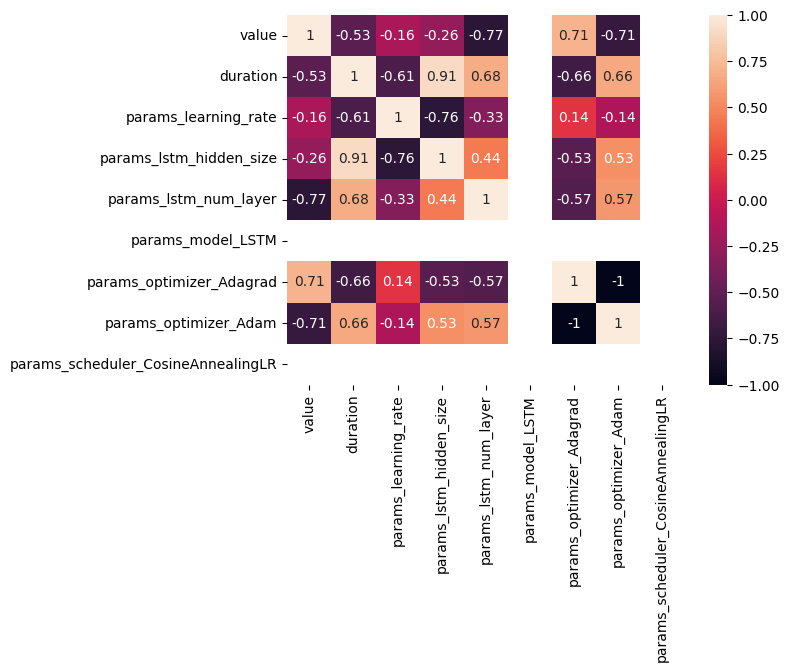

In [16]:
import seaborn as sns
sns.heatmap(pd.get_dummies(df, ['params_model', 'params_optimizer', 'params_scheduler']).corr(), annot=True)